In [1]:
import os
import sys
from learnMSA import msa_hmm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fasta_files = [] #UniProtKB, unaligned sequences
ref_fasta_files = [] #Pfam seed alignments for reference
train_path = "data/large/train/" 
refs_path = "data/large/refs/" 
for file in os.listdir(os.fsencode(train_path)):
    filename = os.fsdecode(file)
    if filename.endswith(".fasta"):
        fasta = msa_hmm.fasta.Fasta(train_path+filename)
        ref_fasta = msa_hmm.fasta.Fasta(refs_path+filename[:-6]+".ref")
        fasta_files.append(fasta)
        ref_fasta_files.append(ref_fasta)

In [3]:
for ref_fasta in ref_fasta_files:
    print(ref_fasta.filename, "\t num seqs:", ref_fasta.num_seq)

data/large/refs/PF13855.9.ref 	 num seqs: 62
data/large/refs/PF00400.35.ref 	 num seqs: 1465
data/large/refs/PF00005.30.ref 	 num seqs: 55
data/large/refs/PF07679.19.ref 	 num seqs: 48
data/large/refs/PF07690.19.ref 	 num seqs: 192
data/large/refs/PF00041.24.ref 	 num seqs: 98
data/large/refs/PF00069.28.ref 	 num seqs: 38
data/large/refs/PF00096.29.ref 	 num seqs: 159
data/large/refs/PF12796.10.ref 	 num seqs: 184
data/large/refs/PF00072.27.ref 	 num seqs: 52


### Sampling 

In [4]:
def sample_subset(fasta, ref_fasta, old_indices, subset_size):
    assert subset_size < old_indices.size, "The sampled subset has to be smaller than the old subset."
    ref_indices = np.array([fasta.seq_ids.index(sid) for sid in ref_fasta.seq_ids])
    for i in ref_indices:
        assert np.where(old_indices == i)[0].size == 1, f"Ref. index {i} is either not at all or multiple times in the old indices array."
    homolog_indices = np.setdiff1d(old_indices, ref_indices)
    homolog_subset = np.random.choice(homolog_indices, size=subset_size-ref_indices.size, replace=False)
    return np.concatenate([ref_indices, homolog_subset], axis=0)

def make_paths(fasta, subset, k):
    filename = os.path.splitext(os.path.basename(fasta.filename))[0]
    subset_fasta_path = f"results/size_scaling/data/subset_fasta/{filename}_{subset.size}_{k}.fasta"
    out_filepath = f"results/size_scaling/data/subset_alignments/{filename}_{subset.size}_{k}.fasta"
    return subset_fasta_path, out_filepath
    

def gen_fasta(fasta, subset, k):
    subset_fasta_path, _ = make_paths(fasta, subset, k)
    if not os.path.exists(subset_fasta_path):
        with open(subset_fasta_path, "w") as subset_fasta:
            for i in subset:
                subset_fasta.write(">"+fasta.seq_ids[i]+"\n")
                subset_fasta.write(fasta.aminoacid_seq_str(i)+"\n")
                

def align_subset(fasta, subset, k):
    subset_fasta_path, out_filepath = make_paths(fasta, subset, k)
    if not os.path.exists(out_filepath):
        subset_fasta = msa_hmm.fasta.Fasta(subset_fasta_path)  
        config = dict(msa_hmm.config.default)
        results = msa_hmm.align.fit_and_align_n(num_runs=1,
                                                fasta_file=subset_fasta, 
                                                config=config,
                                                subset=None)
        best = np.argmax([ll for ll,_ in results])
        best_ll, best_alignment = results[best]
        best_alignment.to_file(out_filepath)

In [5]:
!mkdir -p results/size_scaling/data
!mkdir -p results/size_scaling/data/subset_fasta
!mkdir -p results/size_scaling/data/subset_alignments

In [5]:
np.random.seed(94) 

#number of independent experiments
num_samples = 10 

#defines total subsets sizes (references + homologs) used for the experiments
subset_sizes = [int(i) for i in [1500, 1e4, 2e4, 5e4, 1e5, 2e5, 3e5, 5e5]]

In [6]:
#nested datastructure for the precomputed random subsets
subsets = []
for fasta, ref_fasta in zip(fasta_files, ref_fasta_files):
    indices = [ [np.arange(fasta.num_seq) for _ in range(num_samples)] ]
    for size in reversed(subset_sizes):
        indices.append([])
        for ind in indices[-2]:
            subset = sample_subset(fasta, ref_fasta, ind, size)
            indices[-1].append(subset)
    subsets.append(indices[1:])

In [6]:
#generate sampled files 
for fasta, subsets_by_size in zip(fasta_files, subsets):
    for subset_by_size in subsets_by_size:
        for k, sample in enumerate(subset_by_size):
            gen_fasta(fasta, sample, k)

#ref only files
for fasta, ref_fasta in zip(fasta_files, ref_fasta_files):
    ref_indices = np.array([fasta.seq_ids.index(sid) for sid in ref_fasta.seq_ids])
    gen_fasta(fasta, ref_indices, 0)

### Plots

In [7]:
def load_results(results_file):
    print("\n", results_file)
    results = {}
    with open(results_file, "r") as file:
        for line in file.readlines():
            line = line.rstrip().split()
            if len(line) == 5:
                results[line[0]] = [max(0., float(line[i+1])) for i in range(4)]
    #check for missing files
    missing = 0
    for fasta, subsets_by_size in zip(fasta_files, subsets):
        for subset_by_size in subsets_by_size:
            m = missing
            for k, sample in enumerate(subset_by_size):
                filename = os.path.splitext(os.path.basename(fasta.filename))[0]
                key = f"{filename}_{sample.size}_{k}"
                if not key in results:
                    #print("Missing", key)
                    missing+=1
            if missing - m == 10:
                print("All samples failed:", filename, "size:", sample.size)
    print(f"{missing} files missing: {results_file}")
    return results


 results/size_scaling/learnMSA.out
0 files missing: results/size_scaling/learnMSA.out
learnMSA [74.901 72.927 74.919 75.47  75.695 75.58  75.191 75.086] [100, 100, 100, 100, 100, 100, 100, 100]

 results/size_scaling/reg.out
All samples failed: PF07690.19 size: 500000
All samples failed: PF07690.19 size: 300000
All samples failed: PF07690.19 size: 200000
All samples failed: PF00069.28 size: 500000
All samples failed: PF00069.28 size: 300000
All samples failed: PF12796.10 size: 500000
62 files missing: results/size_scaling/reg.out
reg [58.146 47.581 43.387 40.476 38.013 36.822 34.875 35.05 ] [100, 100, 100, 100, 100, 90, 80, 68]

 results/size_scaling/reg_accurate.out
All samples failed: PF07690.19 size: 500000
All samples failed: PF07690.19 size: 300000
All samples failed: PF00069.28 size: 500000
30 files missing: results/size_scaling/reg_accurate.out
reg_accurate [67.826 62.212 61.365 59.574 58.907 58.469 58.335 57.733] [100, 100, 100, 100, 100, 100, 90, 80]

 results/size_scaling/ma

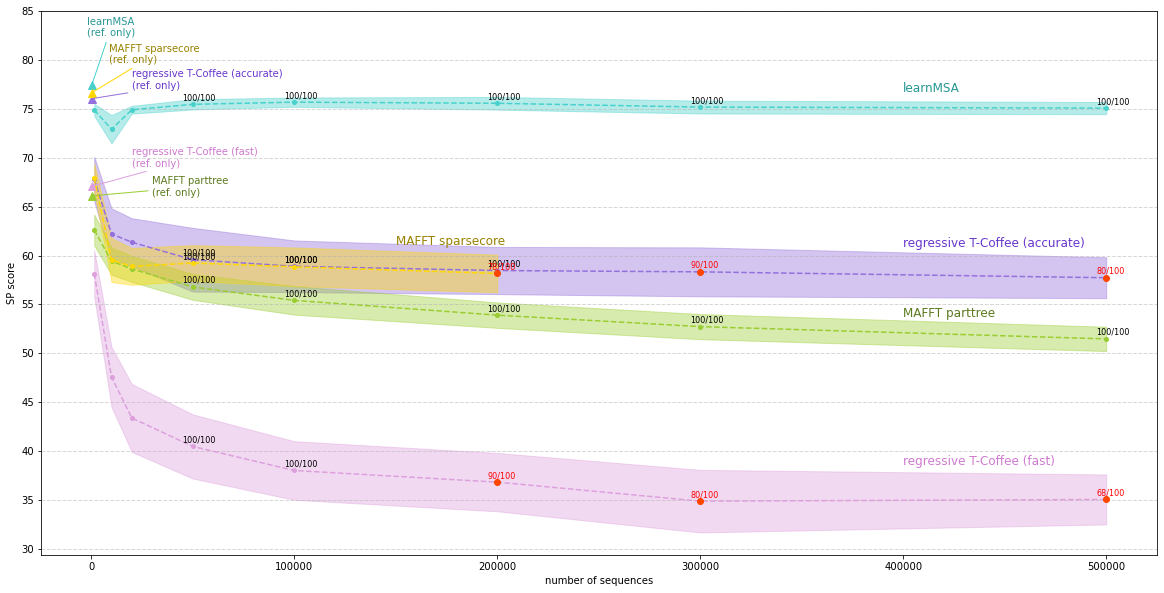

In [11]:
filenames_all = [os.path.splitext(os.path.basename(fasta.filename))[0] for fasta in fasta_files]
filenames = filenames_all

msa_method_keys = ["learnMSA", "reg", "reg_accurate", "mafft", "mafft_sparsecore"]
msa_method_names = ["learnMSA", "regressive T-Coffee (fast)", "regressive T-Coffee (accurate)", "MAFFT parttree", "MAFFT sparsecore"]
msa_method_colors = ["mediumturquoise", "plum", "mediumpurple", "yellowgreen", "gold"] 

#https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
def lighten_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def get_avg(method, score_type = 0, treat_missing_as_zero_score = False):
    results = load_results("results/size_scaling/"+method+".out")
    results_avg = []
    results_sd = []
    found = []
    for s in subset_sizes:
        scores = []
        f = 0
        for j,filename in enumerate(filenames):
            scores.append([])
            for k in range(num_samples):
                key = f"{filename}_{s}_{k}"
                if key in results:
                    scores[-1].append(results[key][score_type])
                    f += 1
                elif treat_missing_as_zero_score:
                    scores[-1].append(0.)
                elif len(results_avg) > 0:
                    scores[-1].append(last_scores[j][k])
        #mean and sd over samples
        avg = [np.mean(s) for s in scores if len(s) > 0]
        sd = [np.std(s) for s in scores if len(s) > 0]
        #average values over families
        results_avg.append(np.mean(avg))
        results_sd.append(np.mean(sd))
        found.append(f)
        last_scores = scores
    results_avg = np.array(results_avg)
    results_sd = np.array(results_sd)
    
    baseline_scores = []
    for filename in filenames:
        s = ref_fasta_files[filenames_all.index(filename)].num_seq
        key = f"{filename}_{s}_0"
        if key in results:
            baseline_scores.append(results[key][score_type])
        elif treat_missing_as_zero_score:
            baseline_scores.append(0.)
            
    baseline_scores = np.mean(baseline_scores)
        
    return results_avg, results_sd, baseline_scores, found
  
ref_depth = [f.num_seq for f in ref_fasta_files]
ref_depth = np.mean(ref_depth)  

total = num_samples*len(filenames)
for key, name, color in zip(msa_method_keys, msa_method_names, msa_method_colors):
    avg_scores, sd_scores, baseline, found = get_avg(key)
    print(key, avg_scores, found)
    s = np.array(subset_sizes)
    f = np.array(found) > 0
    f2 = f & (np.array(found) < 100)
    
    plt.plot(s[f], avg_scores[f], "--o", markersize=4, color=color, label=name)
    plt.plot(s[f2], avg_scores[f2], "o", color="orangered") 
    
    #annotate main graph
    i = 2
    while i < len(found) and found[i] > 0:
        i += 1
    anno_x = (s[i-2] + s[i-1]) / 2
    anno_y = avg_scores[i-1] + sd_scores[i-1] + 1
    plt.annotate(name, 
                 xy=(anno_x, anno_y),
                 fontsize=12,
                 color=lighten_color(color, 1.4))
    
    # refs only
    plt.plot(ref_depth, baseline, "^", markersize=8, color=color)
    if key == "learnMSA":
        xytext = (-2000, baseline+5)
    elif key == "reg":
        xytext = (20000, baseline+2)
    elif key == "mafft":
        xytext = (30000, baseline)
    elif key == "reg_accurate":
        xytext = (20000, baseline+1)
    else:
        xytext = (9000, baseline+3)
    plt.annotate(name+"\n(ref. only)", 
                 xy=(ref_depth, baseline), 
                 xytext=xytext,
                 horizontalalignment="left",
                 color=lighten_color(color, 1.4),
                 fontsize=10, 
                 arrowprops=dict(arrowstyle='-', lw=1, color=color))
            
    #shaded area
    plt.fill_between(s[f], avg_scores[f]-sd_scores[f], avg_scores[f]+sd_scores[f], color=color, alpha=.4)
    
    #found/total labels
    for x,y,num_found,show,missing in list(zip(s, avg_scores, found, f, f2))[3:]:
        if missing:
            c = "r"
        else:
            c = "black"
        if show:
            plt.annotate(f"{num_found}/{total}", (x-5000, y+0.4), fontsize=8, color=c) 
            
plt.grid(linestyle='--', linewidth=1, axis="y", alpha=0.5)
plt.yticks(range(30,90,5))
plt.xlabel("number of sequences")
plt.ylabel("SP score")
plt.rcParams["figure.figsize"] = (20,10)
plt.savefig("fig/size_scaling.pdf", bbox_inches='tight')

In [10]:
#save data as csv
with open("manuscript_data/Figure3.csv", "w") as file:
    file.write("method,family,size,sample,SP,modeler,TC,column\n")
    for m in msa_method_keys:
        results = load_results("results/size_scaling/"+m+".out")
        for key, scores in results.items():
            file.write(",".join([m]+ key.split("_") + [str(s) for s in scores])+"\n")


 results/size_scaling/learnMSA.out
0 files missing: results/size_scaling/learnMSA.out

 results/size_scaling/reg.out
All samples failed: PF07690.19 size: 500000
All samples failed: PF07690.19 size: 300000
All samples failed: PF07690.19 size: 200000
All samples failed: PF00069.28 size: 500000
All samples failed: PF00069.28 size: 300000
All samples failed: PF12796.10 size: 500000
62 files missing: results/size_scaling/reg.out

 results/size_scaling/reg_accurate.out
All samples failed: PF07690.19 size: 500000
All samples failed: PF07690.19 size: 300000
All samples failed: PF00069.28 size: 500000
30 files missing: results/size_scaling/reg_accurate.out

 results/size_scaling/mafft.out
0 files missing: results/size_scaling/mafft.out

 results/size_scaling/mafft_sparsecore.out
All samples failed: PF13855.9 size: 500000
All samples failed: PF13855.9 size: 300000
All samples failed: PF00400.35 size: 500000
All samples failed: PF00400.35 size: 300000
All samples failed: PF00005.30 size: 500000


### Experiment discription

We analyse the effect on alignment accuracy when embedding a static set of reference sequences into increasing numbers of homologs.\
As in our other experiments, the combined sequence sets are aligned and consequently the induced subalignment of the references\
is compared to the corresponding Pfam seed alignment. 

For each of the ultra-large families, we embed the references in nested sets of homologs of increasing size drawn without replacement\
from the respective UnitProtKB dataset. We repeated this sampling precedure 10 times and averaged the results over all experiments and\
families. The shaded area are the standard deviations over the 10 samples, averaged over the families.

For each analysed protein family, this notebook requires a reference alignment and the entire unaligned sequence set of UniProtKB family members.\
Series of random, nested subsets of homologs will be generated and aligned. The alignment is scored based on the induced subalignments of the reference sequences.

### Differences to the experiment from the regressive paper

All analysized families had in total $>500.000$ sequences and therefore no data was excluded at any point. The plotted scores are absolute and not differential. The regressive paper plot averaged over fewer families with increasing number of sequences which means that the estimates decrease in quality.

### Details

The high relative scores of learnMSA can probably be explained by the data. learnMSA has advantages because fragments of full proteins that map to the specific domain are aligned globally.

The accuracy drop at the start of learnMSA's curve is the data point for $10.000$ sequences. For learnMSA as described in the paper, only the upper $50\%$ of the sequences sorted by length are used for training and model surgery (except in the last iteration which used all sequences). This was done to avoid possible negative effects of fragmentary sequences. However, for sequence numbers $\leq 10.000$ the filtering is omitted, i.e. all available sequences are used for training. This artificial bias of the computational method might be visible in the plot by the fact that the data points after $10.000$ use the filtering and the data point for $1500$, which does not use the filtering, has less homologs.

This might also indicate that the threshold of $10.000$, which was optimized on HomFam, might be a suboptimal general choice and should be reevaluated in the future.